In [2]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker, cm
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import leastsq, root, brentq, fsolve
import tqdm

import multiprocessing
from functools import partial

import pycbc.waveform
import cosmolopy.distance as cd

from gwaxion import physics

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)

cosmo = {'omega_M_0':0.308, 'omega_lambda_0':0.692, 'omega_k_0':0.0, 'h':0.678}

# Horizon

To find the horizon we want to set $\rho = 1$, where
\begin{equation*}
\rho \equiv \frac{h_\oplus}{h_{\rm th}(f_\oplus)} = \left( \frac{h_0}{h_{95}} d_0\, {\rm ASD}_{95} \right) \frac{1}{d_z\, {\rm ASD}[f_0\left(1+z\right)^{-1}]}\, ,
\end{equation*}
and $h_\oplus$ and $f_\oplus$ are the GW amplitude and frequency measured at Earth, namely
\begin{align}
h_\oplus &= h_0 \frac{d_0}{d_z}\, ,\\
f_\oplus &= f_0 \left(1+z\right)^{-1}\, ,
\end{align}
with $f_0$ the source-frame GW frequency and $h_0$ the strain at luminosity distance $d_0$.

The denominator in the second factor above can be interpolated for $f_0$ and $z$.

In [3]:
def h95_viterbi(asd_f, T=None, ndet=1):
    # From Lilli: 95% detection efficiency h0 is 4.7e-26 at 201.2 Hz and an ASD of 4E-24 Sqrt[Hz], for T=80 days
    h95ref = 4.7E-26
    f95ref = 201.2
    asd95ref = 4E-24
    Tref = 80*physics.DAYSID_SI
    ndetref = 2
    T = T if T is not None else Tref
    return h95ref * (asd_f/asd95ref) * (Tref/T)**0.25 * (ndetref/float(ndet))**0.5

def euclidean_horizon(h0, f=None, asd_interp=None, dref=5, T=None):
    """ Computes horizon (Mpc) assuming no redshift."""
    asd = asd_interp(f)
    h95 = h95_viterbi(asd, T=T)
    return h0 * dref / h95

def z_to_dl(z):
    return cd.luminosity_distance(z, **cosmo)

## find redshift for a given luminosity distance
def dl_to_z(dl, z0=1):
    return leastsq(lambda z: dl - cd.luminosity_distance(z, **cosmo), z0)[0]

# ## estimate the horizon for recursive evaluation in the main code
# def horizon_dist_eval(h_ratio, d0, z0):
#     guess_dist = d0*h_ratio
#     guess_redshift, res = leastsq(findzfromDL, z0, args=guess_dist)
#     return guess_redshift[0], guess_dist



In [199]:
# define h and z factors

orientation_factor = 2.8  # factor to convert from avg. orientation to optimal orientation
h95ref = 4.7E-26 / orientation_factor
asd95ref = 4E-24
tdriftref = 8*physics.DAYSID_SI

log_d0 = np.log10(5)
log_h95ref = np.log10(h95ref)
log_asd95ref = np.log10(asd95ref)
log_tdriftref = np.log10(tdriftref)

def log_h_factor(h0):
    log_h0 = np.log10(h0)
    log_tdrift = np.log10(tdrift)
    return log_h0 + log_d0 + log_asd95ref - log_h95ref

def log_z_factor(f0, z, asd_interp):
    dz = cd.luminosity_distance(z, **cosmo)
    fz = f0/(1. + z)
    return np.log10(dz * asd_interp(fz))

def log_tdrift_factor(tdrift_src, z):
    # tdrift_src is the tdrift corresponding to fdot in the *source* frame
    # to get the tdrift for fdot in the *detector* frame must redshift
    log_tdrift_det = np.log10(tdrift_src * (1. + z))
    return 0.25*(log_tdrift_det - log_tdriftref)

# horizon-finding functions
def compute_log_zH_brentq(h0, f0, asd_interp, tdrift=tdriftref, log_z_min=-10, log_z_max=2):
    try:
        def remainder(log_z):
            z = 10**log_z
            return log_h_factor(h0) + log_tdrift_factor(tdrift, z) - log_z_factor(f0, z, asd_interp)
        log_zH = brentq(remainder, log_z_min, log_z_max)
    except ValueError:
        log_zH = np.nan
    return log_zH
            
def compute_log_zH_leastsq(h0, f0, asd_interp, log_z_guess=0):
    log_zH = leastsq(lambda log_z: log_h_factor(h0) - log_z_factor(f0, 10**log_z, asd_interp), log_z_guess)[0]
    return log_zH

In [197]:
# find approx redshift for dL = 1 pc
print dl_to_z(1E-6)
print "%.1e pc" % (z_to_dl(2.5E-10)*1E6)

[2.26156457e-10]
1.1e+00 pc


Define functions to use with `multiprocessing`:

In [128]:
reload(physics)
from gwaxion.parallel import *

## Source frame

Load source-frame quantities from disk, or create if not found

In [129]:
dfpath = 'peak_DE.hdf5'
# dfpath = 'peak_DE_both-times.hdf5'
rewrite = False

NCPUS_0 = 8
NCPUS_1 = 8

if os.path.exists(dfpath) and not rewrite:
    print "Loading file: %r" % dfpath
    df_max = pd.read_hdf(dfpath, 'table', mode='r')
        
    n_mass = len(set(df_max['mbh']))
    n_chi = len(set(df_max['chi']))

    print n_mass, n_chi
else:
    print "Finding peak numerically..."
    n_mass = 400
    n_chi = 200
    
    mbhs_array = np.logspace(-1, 4, n_mass)
    chis_array = np.linspace(1E-4, 1, n_chi, endpoint=False)

    distance = 5E6 * physics.PC_SI

    # create mbh_chi array
    mbh_chis = []
    for mbh in mbhs_array:
        for chi in chis_array:
            mbh_chis.append([mbh, chi])
    
    # run over Ms and chis
    pool = MyPool(NCPUS_0)
    rows = pool.map(partial(get_peak_row_time, distance=distance, ncpus=NCPUS_1), mbh_chis)
    df_max = pd.DataFrame(rows)
    df_max.to_hdf(dfpath, 'table', mode='w')
    
# condition data
df_cond = df_max[(df_max['fgw']>=0.01) & (df_max['fgw']<=1E6) & (df_max['h0']>1E-40)].copy()

Loading file: 'peak_DE.hdf5'
200 200


In [130]:
# add a column with boson masses
def get_boson(row):
    return row['fgw']*np.pi*physics.HBAR_SI / physics.EV_SI
#     alpha = physics.Alpha(m_bh=row['mbh'], alpha=row['alpha'])
#     return alpha.m_b_ev

df_cond['boson'] = df_cond.apply(lambda row: get_boson(row), axis=1)
df_max['boson'] = df_cond['boson']

In [131]:
# add a columns with alpha
def get_alpha(row):
    return physics.Alpha(m_bh=row['mbh'], m_b=row['boson'], ev=True, msun=True).alpha

# add a columns with fdot and corresponding Tdrift
def get_fdot(row):
    return (3E-14)*(10. / row['mbh'])**2 * (row['alpha']/0.1)**19 * row['chi']**2

def get_tdrift(row, delta_f=7.23):
    # fdot* Tdrift = delta_f
    # delta_f = 1/(2.*Tdrift)
    # Tdrift = sqrt(2.*fdot)
    return 1./np.sqrt(2.*row['fdot'])

if 'alpha' not in df_cond.keys():
    df_cond['alpha'] = df_cond.apply(lambda row: get_alpha(row), axis=1)
    df_max['alpha'] = df_cond['alpha']

df_cond['fdot'] = df_cond.apply(lambda row: get_fdot(row), axis=1)
df_max['fdot'] = df_cond['fdot']

df_cond['tdrift'] = df_cond.apply(lambda row: get_tdrift(row), axis=1)
df_max['tdrift'] = df_cond['tdrift']

In [132]:
loc = df_cond['fdot'][df_cond['mbh']>1].idxmax()
df_cond.loc[loc]

chi              9.950005e-01
fgw              2.058866e+04
h0               7.162545e-26
mbh              1.203378e+00
boson            4.257392e-11
log_zH_et       -3.221011e+00
log_zH_design   -4.092763e+00
log_zH_voy      -3.785081e+00
log_zH_ce       -3.530853e+00
mu               4.257392e-11
alpha            3.833800e-01
fdot             2.517231e-01
tdrift           1.409365e+00
Name: 8799, dtype: float64

Will have to add a contour to mark values of $\dot f > 10^{-8}$.

# aLIGO design

## PSD

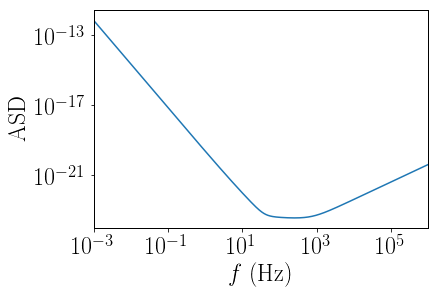

In [39]:
from lalsimulation import SimNoisePSDaLIGOZeroDetHighPower

flow = 0.001
fhig = 1E6
freqs = np.linspace(flow, fhig, int(5E6))

psd_des = np.array([SimNoisePSDaLIGOZeroDetHighPower(f) for f in freqs])
asd_des = psd_des**0.5

psd_des_interp = interp1d(freqs, psd_des)
asd_des_interp = interp1d(freqs, asd_des, bounds_error=False, fill_value=np.inf)

fig, ax = plt.subplots(1)
ax.plot(freqs, asd_des)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(flow, fhig)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

## Diagnose horizon finders

In [200]:
# test horizon finders

%timeit log_zH_leastsq = compute_log_zH_leastsq(5E-26, 200, asd_des_interp)
log_zH_leastsq = compute_log_zH_leastsq(5E-26, 200, asd_des_interp)
print z_to_dl(10**log_zH_leastsq)

%timeit log_zH_brentq = compute_log_zH_brentq(5E-26, 200, asd_des_interp)
log_zH_brentq = compute_log_zH_brentq(5E-26, 200, asd_des_interp)
print z_to_dl(10**log_zH_leastsq)

%timeit log_zH_brentq = compute_log_zH_brentq(5E-26, 200, asd_des_interp, log_z_min=-9, log_z_max=0)
log_zH_brentq = compute_log_zH_brentq(5E-26, 200, asd_des_interp)
print z_to_dl(10**log_zH_leastsq)


The slowest run took 47.21 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 3.43 ms per loop
[16.41349123]
The slowest run took 17.44 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 3.78 ms per loop
[16.41349123]
100 loops, best of 3: 2.26 ms per loop
[16.41349123]


In [201]:
h0_array = np.logspace(-27, -22, 50)
f0_array = np.logspace(np.log10(30), 4, 50)

# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0
h0s, f0s, log_zHs = [], [], []
with tqdm.tqdm(range(len(h0_array)*len(f0_array))) as pbar:
    for h0 in h0_array:
        for f0 in f0_array:
            log_zHs.append(compute_log_zH_brentq(h0, f0, asd_des_interp))
            h0s.append(h0)
            f0s.append(f0)
            pbar.update()
            
h0s = np.array(h0s)
f0s = np.array(f0s)
log_zHs = np.array(log_zHs)

100%|██████████| 2500/2500 [00:09<00:00, 263.69it/s]


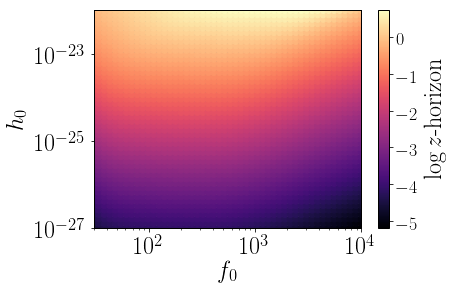

In [202]:
# diagnose interpolant data

fig, ax = plt.subplots(1)
cm = ax.scatter(f0s, h0s, c=log_zHs, cmap='magma')

# add colorbar
cb = plt.colorbar(cm, label=r'$\log z$-horizon')
cb.ax.tick_params(labelsize=18) 

plt.xlabel(r'$f_0$')
plt.ylabel(r'$h_0$')
ax.patch.set_facecolor("grey")

plt.xscale('log')
plt.yscale('log')

plt.xlim(30, 1E4)
plt.ylim(1E-27, 1E-22)

plt.show()
plt.close()

## Range

In [215]:
# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0

log_zHs_des = []
with tqdm.tqdm(range(len(df_cond))) as pbar:
    for h0, f0, tdrift in zip(df_cond['h0'], df_cond['fgw'], df_cond['tdrift']):
        log_zHs_des.append(compute_log_zH_brentq(h0, f0, asd_des_interp, tdrift=tdrift))
        pbar.update()        
log_zHs_des = np.array(log_zHs_des)

100%|██████████| 36412/36412 [02:03<00:00, 295.61it/s]


In [227]:
np.nanmax(log_zHs_des)

-0.6625961575128584

In [216]:
df_cond['log_zH_des'] = log_zHs_des
fname, ext = os.path.splitext(dfpath)
# df_cond.to_hdf('%s_design%s' % (fname, ext), 'table', mode='w')
df_max['log_zH_des'] = df_cond['log_zH_des']

In [217]:
from gwaxion import utilities
reload(utilities)

<module 'gwaxion.utilities' from '/home/misi/.local/lib/python2.7/site-packages/gwaxion/utilities.pyc'>

In [225]:
print df_cond['h0'].max()
print df_cond['fgw'].max()
print df_cond['tdrift'].max(), df_cond['tdrift'].min()

 5.953048589632795e-22
241660.1913721835
3.2201410715380974e+20 0.1484082818099595


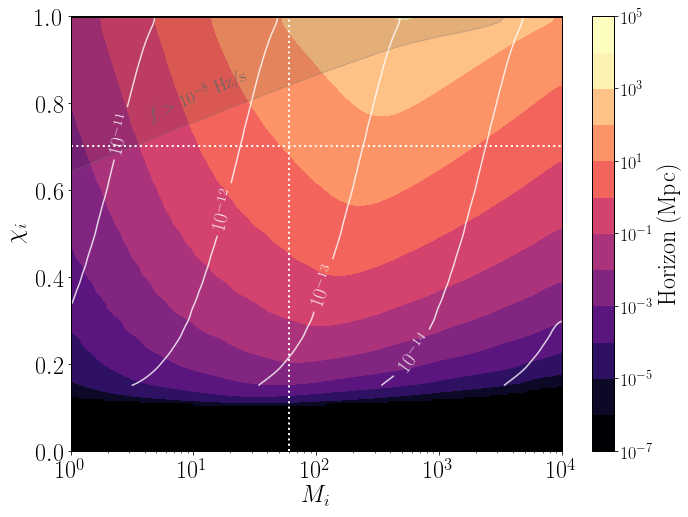

In [218]:
# contours

X = df_max['mbh'].reshape(n_chi, n_mass)
Y = df_max['chi'].reshape(n_chi, n_mass)
logzs = np.ma.masked_array(df_max['log_zH_des'], mask=((df_max['fgw']<0.01) | (df_max['fgw']>1E6) | (df_max['h0']<1E-40)))
Z = z_to_dl(10**logzs).reshape(n_chi, n_mass)
#np.ma.set_fill_value(Z, 0)Z = z_to_dl(10**logzs)

fig, ax = plt.subplots(1, figsize=(11,8))
# ax2 = ax.twiny()

zmin, zmax = 1E-6, 1E4
norm = matplotlib.colors.LogNorm(vmin=zmin, vmax=zmax)

## smooth the contours
Z_denoised = utilities.smooth_data(Z, vmin=zmin)

cm = ax.contourf(X, Y, Z_denoised, cmap='magma', locator=ticker.LogLocator(numticks=48,base=10), norm=norm)

## let's add boson mass contours
Z = utilities.smooth_data(df_max['boson'].reshape(n_chi, n_mass), sigma=3)
Z = np.ma.masked_array(Z, mask=((Y<0.15)))
cs = ax.contour(X, Y, Z, colors='white', locator=ticker.LogLocator(numticks=48,base=10), alpha=0.8)
fmt = lambda v: r"$10^{%i}$" % np.log10(v)
locs = None#[(2E3, 0.5), (2E2, 0.5), (2E1, 0.5), (2E0, 0.5)]
plt.clabel(cs, cs.levels[1:], inline=1, fmt=fmt, fontsize=20, use_clabeltext=True, manual=locs)


## let's add fdot_det contours
fdot_det = df_max['fdot']*(1. + 10**logzs)**(-2)
Z = utilities.smooth_data(fdot_det.reshape(n_chi, n_mass), sigma=3)
Z = np.ma.masked_array(Z, mask=((Y<0.15)))
cs = ax.contour(X, Y, Z, colors=('gray',), levels=(1E-8, 10,), alpha=0.2)
ax.contourf(X, Y, Z, colors='none', levels=[1E-8, 1], alpha=0.1)
# fmt = lambda v: r"$\dot f = 10^{%i}$ Hz/s" % np.log10(v)
# locs = [(10, 0.75)]
# plt.clabel(cs, inline=1, fmt=fmt, fontsize=18)#, manual=locs)

ax.annotate(r"$\dot f > 10^{-8}$ Hz/s", xy=(0.15, 0.75), xycoords="axes fraction", 
            ha='left', va='bottom', fontsize=18, color='0.4', rotation=23)


# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
cb = plt.colorbar(cm, label=r'Horizon (Mpc)', norm=norm)
cb.ax.tick_params(labelsize=18) 

ax.set_xlabel(r'$M_i$')
ax.set_ylabel(r'$\chi_i$')
ax.patch.set_facecolor("black")

ax.set_xscale('log')

ax.set_xlim(1, 1E4)
ax.set_ylim(0, 1)

#fig.savefig('cont_chi_mbh_range_design_DE_tdrift.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

In [147]:
# # hexbin

# x = df_cond['mbh']
# y = df_cond['chi']
# C = z_to_dl(10**df_cond['log_zH_des'])#*1E3

# fig, ax = plt.subplots(1, figsize=(11,8))
# norm = matplotlib.colors.LogNorm(vmin=1E-6, vmax=C.max())
# cm = ax.hexbin(x, y, C=C, cmap='magma', norm=norm, xscale='log')
# cm.set_rasterized(True)

# #cs = ax.contour(X, Y, Z_denoised, colors='white', locator=ticker.LogLocator(numticks=48,base=10), alpha=0.5)

# levels = np.arange(-4, 4, 1)
# strs = [r'$10^{%i}$' % i for i in levels]
# cs = ax.contour(X, Y, Z_denoised, colors='0.5', linewidths=(2,), levels=10.**levels, alpha=0.5)
# fmt = {l: s for l, s in zip(cs.levels, strs)}
# plt.clabel(cs, cs.levels[::1], inline=True, fmt=fmt, fontsize=22)

# # plot vertical line at 60 Msun
# ax.axvline(60, c='w', ls=':', lw=2)
# ax.axhline(0.7, c='w', ls=':', lw=2)

# # add colorbar
# cb = plt.colorbar(cm, label=r'Horizon (Mpc)', norm=norm)
# cb.ax.tick_params(labelsize=18) 

# plt.xlabel(r'$M$')
# plt.ylabel(r'$\chi$')
# ax.patch.set_facecolor("black")

# plt.xscale('log')

# ax.set_xlim(1, 1E4)
# plt.ylim(0, 1)

# fig.savefig('cmap_chi_mbh_range_design_DE.pdf', bbox_inches='tight', dpi=400)

# plt.show()
# plt.close()

In [219]:
z_max = 10**df_cond['log_zH_des'].max()
print "Maximum horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(z_max), z_max)
# GW150914
fdot = get_fdot({'mbh': 60, 'chi': 0.7, 'alpha': 0.178})
tdrift = get_tdrift({'fdot': fdot})
test_z = 10**compute_log_zH_brentq(5E-26, 200, asd_des_interp, tdrift=tdrift)
print "GW150914 horizon (8 days): %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)
test_z = 10**compute_log_zH_leastsq(5E-26, 200, asd_des_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)

Maximum horizon: 1110.0 Mpc (z=2.2e-01)
GW150914 horizon (8 days): 11.1 Mpc (z=2.5e-03)
GW150914 horizon: 16.4 Mpc (z=3.7e-03)


In [247]:
print "Computing examples..."
name = 'ce'
asd_interp = asd_ce_interp
# EXAMPLES
distance = 5E6*physics.PC_SI
mbh_chis = [(3, 0.9), (10, 0.9), (60, 0.7), (60, 0.9), (200, 0.85), (400, 0.9)]
df = pd.DataFrame([get_peak_row_time(mbh_chi, distance=distance) for mbh_chi in mbh_chis])
df['mu'] = df.apply(lambda row: get_boson(row), axis=1)
df['fdot'] = df.apply(lambda row: get_fdot(row), axis=1)
df['tdrift'] = df.apply(lambda row: get_tdrift(row), axis=1)
log_zHs = []
for h0, f0, tdrift in zip(df['h0'], df['fgw'], df['tdrift']):
    log_zHs.append(compute_log_zH_brentq(h0, f0, asd_interp, tdrift=tdrift))
log_zHs = np.array(log_zHs)
df['zH_%s' % name] = 10**log_zHs
df['H_%s' % name] = z_to_dl(10**log_zHs)
print df


Computing examples...
   alpha   chi          fgw            h0  mbh           tgw         tinst  \
0   0.27  0.90  5767.275125  3.729573e-26    3  5.945493e+07  7.262850e+03   
1   0.27  0.90  1730.175867  1.237378e-25   10  1.989240e+08  2.420950e+04   
2   0.18  0.70   193.115249  5.203663e-26   60  2.296562e+11  3.337609e+06   
3   0.27  0.90   288.362653  7.424534e-25   60  1.193509e+09  1.452570e+05   
4   0.24  0.85    77.026606  1.254600e-24  200  1.613135e+10  1.049308e+06   
5   0.27  0.90    43.254384  4.947744e-24  400  7.959222e+09  9.683799e+05   

             mu          fdot         tdrift     zH_ce          H_ce  
0  1.192577e-11  4.239116e-05     108.604385  0.000467      2.065217  
1  3.577716e-12  3.815204e-06     362.014617  0.008058     35.849366  
2  3.993302e-13  2.891961e-11  131488.807504  0.054859    252.601430  
3  5.962860e-13  1.059779e-07    2172.087700  0.250507   1302.159079  
4  1.592782e-13  9.076381e-10   23470.840844  0.712228   4475.555049  
5  8.

In [232]:
df['tinst'] / physics.DAYSID_SI

0     0.084291
1     0.280970
2    38.735499
3     1.685818
4    12.178021
5     8.429091
Name: tinst, dtype: float64

In [233]:
df['tgw'] / physics.YRSID_SI

0       1.883980
1       6.303410
2    7277.239111
3      37.819372
4     511.162795
5     189.156009
Name: tgw, dtype: float64

In [221]:
max_loc = df_cond['log_zH_%s' % name].idxmax()
max_z = 10**df_cond['log_zH_%s' % name].max()
print "\n Furthest horizon: %.1f Mpc (z=%.2e)" % (z_to_dl(max_z), max_z)
print pd.DataFrame([df_cond.loc[max_loc][['mbh', 'chi', 'alpha', 'boson', 'h0', 'fgw', 'fdot', 'tinst']]])



 Furthest horizon: 1110.0 Mpc (z=2.17e-01)
              mbh       chi     alpha         boson            h0        fgw  \
29799  523.109931  0.995001  0.364453  9.310318e-14  3.073312e-23  45.024498   

               fdot  tinst  
29799  5.090561e-07    NaN  


Technically, we should have also redshifted the frequency derivative: $\dot f_{\rm det} = \dot f_{\rm src} (1+z)^{-2}$.
How big is this effect?

In [249]:
dl_to_z(1E4)

array([1.36853444])

# Voyager

Voyager band:
6.0116914 5000.0


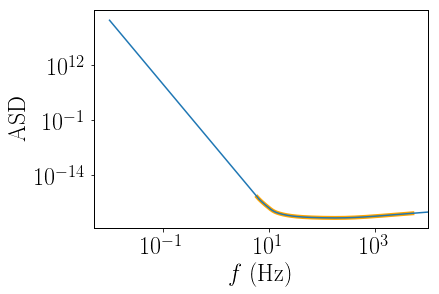

In [82]:
# load Voyager ASD
vals = np.loadtxt('noise_curves_T1500293-v10/voyager.txt')
fs, asd_voy_array = vals[:,0], vals[:,1]

# this curve has an artificial turn around 5.02 Hz so discard those points before extrapolation
f_cut = 6
asd_voy_array = asd_voy_array[fs>f_cut]
fs = fs[fs>f_cut]

print "Voyager band:"
print fs.min(), fs.max()

# create interpolant (in logspace)
log_asd_voy_interp = interp1d(np.log10(fs), np.log10(asd_voy_array), fill_value='extrapolate')
def asd_voy_interp(f): lasd=log_asd_voy_interp(np.log10(f)); return 10**lasd

fmin, fmax = 1E-2, 1E4 #freqs.min(), freqs.max()
freqs = np.logspace(np.log10(fmin), np.log10(fmax), int(1E6))

fig, ax = plt.subplots(1)
ax.plot(fs, asd_voy_array, lw=4, color='orange')
ax.plot(freqs, asd_voy_interp(freqs))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin*0.5, fmax)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)


In [114]:
# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0
log_zHs_voy = []
with tqdm.tqdm(range(len(df_cond))) as pbar:
    for h0, f0, tdrift in zip(df_cond['h0'], df_cond['fgw'], df_cond['tdrift']):
        log_zHs_voy.append(compute_log_zH_brentq(h0, f0, asd_voy_interp, tdrift=tdrift))
        pbar.update()        
log_zHs_voy = np.array(log_zHs_voy)

100%|██████████| 36412/36412 [02:02<00:00, 298.24it/s]


In [115]:
df_cond['log_zH_voy'] = log_zHs_voy
# df_cond.to_hdf('new_peak_horizon_voy.hdf5', 'table', mode='w')
df_max['log_zH_voy'] = df_cond['log_zH_voy']

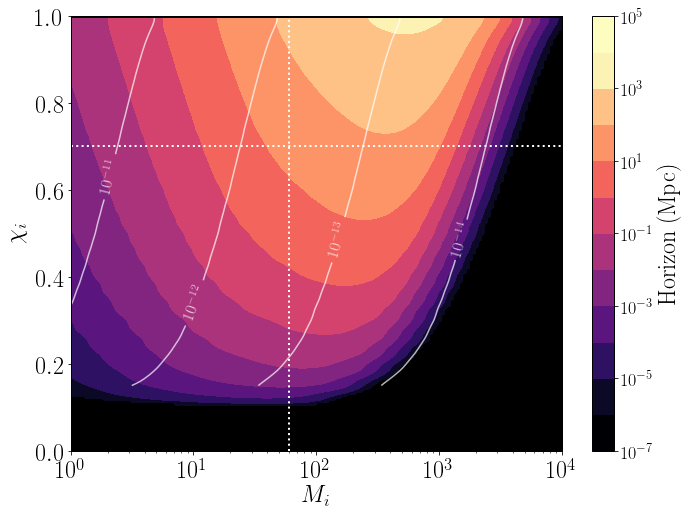

In [116]:
X = df_max['mbh'].reshape(n_chi, n_mass)
Y = df_max['chi'].reshape(n_chi, n_mass)
logzs = np.ma.masked_array(df_max['log_zH_voy'], mask=((df_max['fgw']<0.01) | (df_max['fgw']>1E6) | (df_max['h0']<1E-40)))
Z = z_to_dl(10**logzs).reshape(n_chi, n_mass)
## smooth the contours
Z = utilities.smooth_data(Z, vmin=zmin)

x = df_cond['mbh']
y = df_cond['chi']
C = z_to_dl(10**df_cond['log_zH_voy'])

# contours

fig, ax = plt.subplots(1, figsize=(11,8))

zmin, zmax = 1E-6, 1E4
norm = matplotlib.colors.LogNorm(vmin=zmin, vmax=zmax)

cm = ax.contourf(X, Y, Z, cmap='magma', locator=ticker.LogLocator(numticks=48,base=10), norm=norm)
#cm.set_rasterized(True)

## let's add boson mass contours
Z = utilities.smooth_data(df_max['boson'].reshape(n_chi, n_mass), sigma=3)
Z = np.ma.masked_array(Z, mask=(Y<0.15) | (Z<5E-15))
cs = ax.contour(X, Y, Z, colors='white', locator=ticker.LogLocator(numticks=48,base=10), alpha=0.7)
fmt = lambda v: r"$10^{%i}$" % np.log10(v)
locs = None#[(2E3, 0.5), (2E2, 0.5), (2E1, 0.5), (2E0, 0.5)]
plt.clabel(cs, inline=1, fmt=fmt, fontsize=16, use_clabeltext=True, manual=locs)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#m = plt.cm.ScalarMappable(cmap='magma')
#m.set_array(Z_denoised)
#m.set_clim(1e-6, 1e3)
cb = plt.colorbar(cm, label=r'Horizon (Mpc)', extend='both')
cb.ax.tick_params(labelsize=18) 

ax.set_xlabel(r'$M_i$')
ax.set_ylabel(r'$\chi_i$')
ax.patch.set_facecolor("black")

plt.xscale('log')

ax.set_xlim(1, 1E4)
ax.set_ylim(0, 1)

fig.savefig('cont_chi_mbh_range_voyager_DE_tdrift.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

In [117]:
C.max()

1504.4392086160035

In [155]:
# # plot
# fig, ax = plt.subplots(1, figsize=(11,8))
# cmin, cmax = 1E-6, np.nanmax(C)  # np.nanmin(C), np.nanmax(C)
# norm = matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax)
# cm = ax.hexbin(x, y, C=C, cmap='magma', norm=norm, xscale='log')
# cm.set_rasterized(True)

# levels = np.arange(-4, 4, 1)
# strs = [r'$10^{%i}$' % i for i in levels]
# cs = ax.contour(X, Y, Z, colors='0.5', linewidths=(2,), levels=10.**levels, alpha=0.5)
# fmt = {l: s for l, s in zip(cs.levels, strs)}
# plt.clabel(cs, cs.levels[::1], inline=True, fmt=fmt, fontsize=22)

# # plot vertical line at 60 Msun
# ax.axvline(60, c='w', ls=':', lw=2)
# ax.axhline(0.7, c='w', ls=':', lw=2)

# # add colorbar
# cb = plt.colorbar(cm, label=r'Horizon (Mpc)', norm=norm)
# cb.ax.tick_params(labelsize=18) 

# plt.xlabel(r'$M$')
# plt.ylabel(r'$\chi$')
# ax.patch.set_facecolor("black")

# plt.xscale('log')

# ax.set_xlim(1, 1E4)
# plt.ylim(0, 1)

# fig.savefig('cmap_chi_mbh_range_voyager_DE.pdf', bbox_inches='tight', dpi=400)

# plt.show()
# plt.close()

In [156]:
print "Maximum redshift: %.2e" % (10**df_cond['log_zH_voy'].max())
test_z = 10**compute_log_zH_brentq(4E-26, 200, asd_voy_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)
test_z = 10**compute_log_zH_leastsq(4E-26, 200, asd_voy_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)

Maximum redshift: 8.69e-01
GW150914 horizon: 20.1 Mpc (z=4.5e-03)
GW150914 horizon: 20.1 Mpc (z=4.5e-03)


# Cosmic Explorer

CE band:
5.0 5000.0


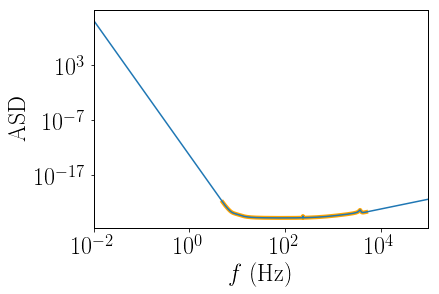

In [238]:
# load Voyager ASD
vals = np.loadtxt('noise_curves_T1500293-v10/ce.txt')
fs, asd_ce_array = vals[:,0], vals[:,1]

print "CE band:"
print fs.min(), fs.max()

# create interpolant (in logspace)
log_asd_ce_interp = interp1d(np.log10(fs), np.log10(asd_ce_array), fill_value='extrapolate')
def asd_ce_interp(f): lasd=log_asd_ce_interp(np.log10(f)); return 10**lasd

fmin, fmax = 1E-2, 1E5 #freqs.min(), freqs.max()
freqs = np.logspace(np.log10(fmin), np.log10(fmax), int(1E6))

fig, ax = plt.subplots(1)
ax.plot(fs, asd_ce_array, lw=4, color='orange')
ax.plot(freqs, asd_ce_interp(freqs))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

In [158]:
# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0
log_zHs_ce = []
with tqdm.tqdm(range(len(df_cond))) as pbar:
    for h0, f0 in zip(df_cond['h0'], df_cond['fgw']):
        log_zHs_ce.append(compute_log_zH_brentq(h0, f0, asd_ce_interp))
        pbar.update()        
log_zHs_ce = np.array(log_zHs_ce)

100%|██████████| 36412/36412 [02:06<00:00, 287.50it/s]


In [159]:
df_cond['log_zH_ce'] = log_zHs_ce
df_max['log_zH_ce'] = df_cond['log_zH_ce']

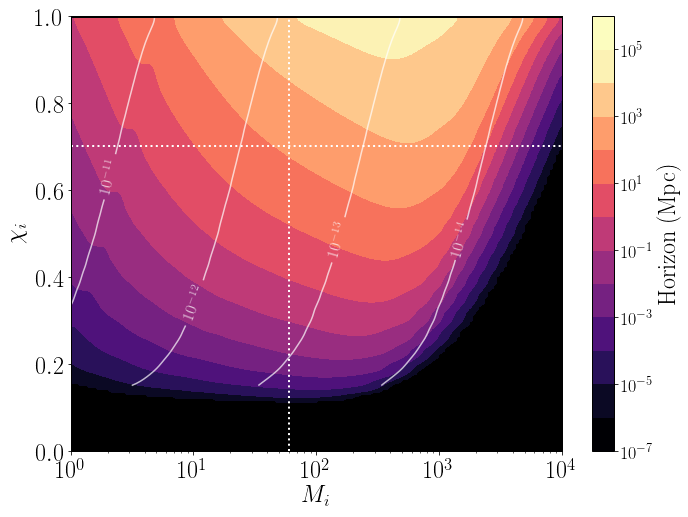

In [217]:
X = df_max['mbh'].reshape(n_chi, n_mass)
Y = df_max['chi'].reshape(n_chi, n_mass)
logzs = np.ma.masked_array(df_max['log_zH_ce'], mask=((df_max['fgw']<0.01) | (df_max['fgw']>1E6) | (df_max['h0']<1E-40)))
Z = z_to_dl(10**logzs).reshape(n_chi, n_mass)
## smooth the contours
Z = utilities.smooth_data(Z, vmin=zmin)

x = df_cond['mbh']
y = df_cond['chi']
C = z_to_dl(10**df_cond['log_zH_ce'])

# contours

fig, ax = plt.subplots(1, figsize=(11,8))

zmin, zmax = 1E-6, 1E5
norm = matplotlib.colors.LogNorm(vmin=zmin, vmax=zmax)

cm = ax.contourf(X, Y, Z, cmap='magma', locator=ticker.LogLocator(numticks=48,base=10), norm=norm)

## let's add boson mass contours
Z = utilities.smooth_data(df_max['boson'].reshape(n_chi, n_mass), sigma=3)
Z = np.ma.masked_array(Z, mask=((Y<0.15) | (Z<5E-15)))
cs = ax.contour(X, Y, Z, colors='white', locator=ticker.LogLocator(numticks=48,base=10), alpha=0.7)
fmt = lambda v: r"$10^{%i}$" % np.log10(v)
locs = None#[(2E3, 0.5), (2E2, 0.5), (2E1, 0.5), (2E0, 0.5)]
plt.clabel(cs, inline=1, fmt=fmt, fontsize=16, use_clabeltext=True, manual=locs)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#m = plt.cm.ScalarMappable(cmap='magma')
#m.set_array(Z_denoised)
#m.set_clim(1e-6, 1e3)
cb = plt.colorbar(cm, label=r'Horizon (Mpc)', extend='both')
cb.ax.tick_params(labelsize=18) 

plt.xlabel(r'$M_i$')
plt.ylabel(r'$\chi_i$')
ax.patch.set_facecolor("black")

ax.set_xscale('log')

ax.set_xlim(1, 1E4)
ax.set_ylim(0, 1)

fig.savefig('cont_chi_mbh_range_ce_DE.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

In [198]:
C.max()

33473.47491163586

In [163]:
# # plot
# fig, ax = plt.subplots(1, figsize=(11,8))
# cmin, cmax = 1E-6, np.nanmax(C)  # np.nanmin(C), np.nanmax(C)
# norm = matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax)
# cm = ax.hexbin(x, y, C=C, cmap='magma', norm=norm, xscale='log')
# cm.set_rasterized(True)

# levels = np.arange(-4, 4, 1)
# strs = [r'$10^{%i}$' % i for i in levels]
# cs = ax.contour(X, Y, Z, colors='0.5', linewidths=(2,), levels=10.**levels, alpha=0.5)
# fmt = {l: s for l, s in zip(cs.levels, strs)}
# plt.clabel(cs, cs.levels[::1], inline=True, fmt=fmt, fontsize=22)

# # plot vertical line at 60 Msun
# ax.axvline(60, c='w', ls=':', lw=2)
# ax.axhline(0.7, c='w', ls=':', lw=2)

# # add colorbar
# cb = plt.colorbar(cm, label=r'Horizon (Mpc)', norm=norm)
# cb.ax.tick_params(labelsize=18) 

# plt.xlabel(r'$M$')
# plt.ylabel(r'$\chi$')
# ax.patch.set_facecolor("black")

# plt.xscale('log')

# ax.set_xlim(1, 1E4)
# plt.ylim(0, 1)

# fig.savefig('cmap_chi_mbh_range_ce_DE.pdf', bbox_inches='tight', dpi=400)

# plt.show()
# plt.close()

In [200]:
print "Maximum redshift: %.2e" % (10**df_cond['log_zH_ce'].max())
test_z = 10**compute_log_zH_brentq(4E-26, 200, asd_ce_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)
test_z = 10**compute_log_zH_leastsq(4E-26, 200, asd_ce_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)

Maximum redshift: 3.70e+00
GW150914 horizon: 102.7 Mpc (z=2.3e-02)
GW150914 horizon: 102.7 Mpc (z=2.3e-02)


# Einstein Telescope

ET band:
1.5045009 1000000.0


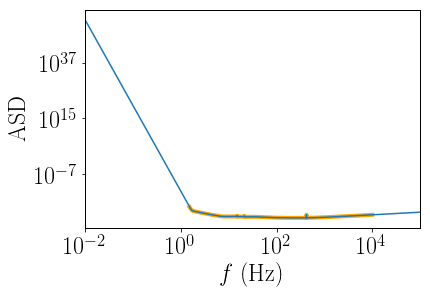

In [237]:
# load Voyager ASD
vals = np.loadtxt('noise_curves_T1500293-v10/et_d.txt')
fs, asd_et_array = vals[:,0], vals[:,1]

# this curve has an artificial turn around 1.01 Hz so discard those points before extrapolation
f_cut = 1.5
asd_et_array = asd_et_array[fs>f_cut]
fs = fs[fs>f_cut]

print "ET band:"
print fs.min(), f.max()

# create interpolant (in logspace)
log_asd_et_interp = interp1d(np.log10(fs), np.log10(asd_et_array), fill_value='extrapolate')
def asd_et_interp(f): lasd=log_asd_et_interp(np.log10(f)); return 10**lasd

fmin, fmax = 1E-2, 1E5 #freqs.min(), freqs.max()
freqs = np.logspace(np.log10(fmin), np.log10(fmax), int(1E6))

fig, ax = plt.subplots(1)
ax.plot(fs, asd_et_array, lw=4, color='orange')
ax.plot(freqs, asd_et_interp(freqs))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

In [166]:
# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0
log_zHs_et = []
with tqdm.tqdm(range(len(df_cond))) as pbar:
    for h0, f0 in zip(df_cond['h0'], df_cond['fgw']):
        log_zHs_et.append(compute_log_zH_brentq(h0, f0, asd_et_interp))
        pbar.update()        
log_zHs_et = np.array(log_zHs_et)

100%|██████████| 36412/36412 [02:08<00:00, 284.09it/s]


In [167]:
df_cond['log_zH_et'] = log_zHs_et
df_max['log_zH_et'] = df_cond['log_zH_et']

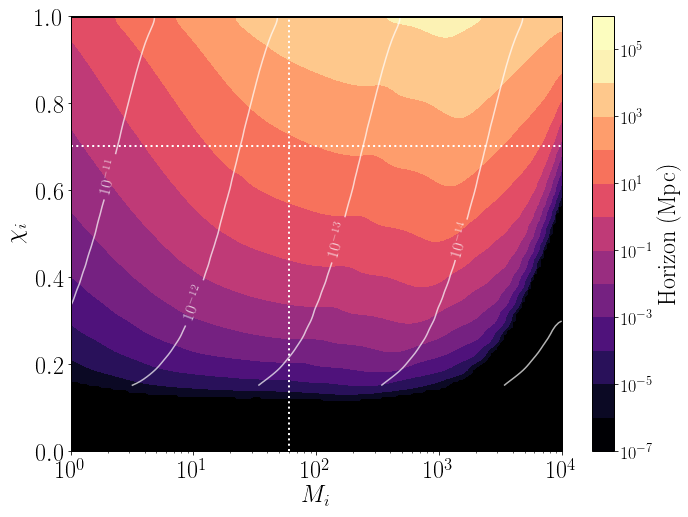

In [218]:
X = df_max['mbh'].reshape(n_chi, n_mass)
Y = df_max['chi'].reshape(n_chi, n_mass)
logzs = np.ma.masked_array(df_max['log_zH_et'], mask=((df_max['fgw']<0.01) | (df_max['fgw']>1E6) | (df_max['h0']<1E-40)))
Z = z_to_dl(10**logzs).reshape(n_chi, n_mass)
## smooth the contours
Z = utilities.smooth_data(Z, vmin=zmin)

x = df_cond['mbh']
y = df_cond['chi']
C = z_to_dl(10**df_cond['log_zH_et'])
# contours

fig, ax = plt.subplots(1, figsize=(11,8))

zmin, zmax = 1E-6, 1E5
norm = matplotlib.colors.LogNorm(vmin=zmin, vmax=zmax)

cm = ax.contourf(X, Y, Z, cmap='magma', locator=ticker.LogLocator(numticks=48,base=10), norm=norm)

## let's add boson mass contours
Z = utilities.smooth_data(df_max['boson'].reshape(n_chi, n_mass), sigma=3)
Z = np.ma.masked_array(Z, mask=((Y<0.15)))
cs = ax.contour(X, Y, Z, colors='white', locator=ticker.LogLocator(numticks=48,base=10), alpha=0.7)
fmt = lambda v: r"$10^{%i}$" % np.log10(v)
locs = None#[(2E3, 0.5), (2E2, 0.5), (2E1, 0.5), (2E0, 0.5)]
plt.clabel(cs, cs.levels[1:], inline=1, fmt=fmt, fontsize=16, use_clabeltext=True, manual=locs)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#m = plt.cm.ScalarMappable(cmap='magma')
#m.set_array(Z_denoised)
#m.set_clim(1e-6, 1e3)
cb = plt.colorbar(cm, label=r'Horizon (Mpc)', extend='both')
cb.ax.tick_params(labelsize=18) 

ax.set_xlabel(r'$M_i$')
ax.set_ylabel(r'$\chi_i$')
ax.patch.set_facecolor("black")

ax.set_xscale('log')

ax.set_xlim(1, 1E4)
ax.set_ylim(0, 1)

fig.savefig('cont_chi_mbh_range_et_DE.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

In [208]:
C.max()

19671.808105906308

In [171]:
max_z = 10**df_cond['log_zH_et'].max()
print "Maximum redshift: %.2e Mpc (z=%.1e)" % (z_to_dl(max_z), max_z)
test_z = 10**compute_log_zH_brentq(4E-26, 200, asd_et_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)
test_z = 10**compute_log_zH_leastsq(4E-26, 200, asd_et_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)

Maximum redshift: 1.97e+04 Mpc (z=2.4e+00)
GW150914 horizon: 51.9 Mpc (z=1.2e-02)
GW150914 horizon: 51.9 Mpc (z=1.2e-02)


# PSD and h95's

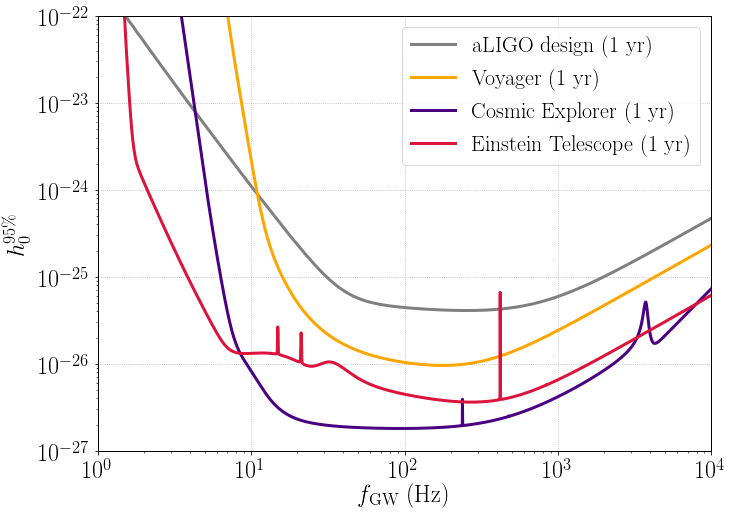

In [172]:
# use Voyager frequency array for the x-axis

year = 365*physics.DAYSID_SI

freqs = np.logspace(0, 4, int(1E5))

fig, ax = plt.subplots(1, figsize=(11,8))
# ax.plot(freqs, h95_viterbi(asd_des_interp(freqs), T=80*physics.DAYSID_SI, ndet=10), label="aLIGO design (80 days, 10)", lw=3, c='cyan', ls='--')
# ax.plot(freqs, h95_viterbi(asd_des_interp(freqs), T=80*physics.DAYSID_SI, ndet=2), label="aLIGO design (80 days)", lw=3, c='gray', ls='--')
ax.plot(freqs, h95_viterbi(asd_des_interp(freqs), T=year), label="aLIGO design (1 yr)", lw=3, c='gray')
ax.plot(freqs, h95_viterbi(asd_voy_interp(freqs), T=year), label="Voyager (1 yr)", lw=3, c='orange')
ax.plot(freqs, h95_viterbi(asd_ce_interp(freqs), T=year), label="Cosmic Explorer (1 yr)", lw=3, c='indigo')
ax.plot(freqs, h95_viterbi(asd_et_interp(freqs), T=year), label="Einstein Telescope (1 yr)", lw=3, c='crimson')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(freqs.min(), freqs.max())
ax.set_ylim(1E-27, 1E-22)

ax.set_xlabel(r'$f_{\rm GW}$ (Hz)')
ax.set_ylabel(r'$h^{95\%}_0$')

ax.legend(loc='best', fontsize=22)
ax.grid(True, ls=':')

fig.savefig('plot_h095_fgw.pdf', bbox_inches='tight')

plt.show(fig)
plt.close()